In [1]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../.")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import sate

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
SATE_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_sate_spaceaug_0045.h5")
# Download COCO trained weights from Releases if needed

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "trainimages")
OutIMAGE_DIR = "/home/ashwin/Desktop/Test/jupyter_output"

/home/ashwin/miniconda3/envs/dlenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
class InferenceConfig(sate.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [4]:
# Sate Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG','building']

In [5]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=inference_config)

# Load weights trained on MS-COCO
model.load_weights(SATE_MODEL_PATH, by_name=True)#,exclude=["mrcnn_bbox_fc", "mrcnn_class_logits", "mrcnn_mask"])

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [6]:
dataset_val = sate.CocoDataset()
val_type = "val" 
dataset_path = "/home/ashwin/Desktop/SpaceNet/Mask_RCNN/samples/coco"
dataset_val.load_coco(dataset_path, val_type, year="2018")
dataset_val.prepare()

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  int64
gt_class_id              shape: (71,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (71, 4)               min:    0.00000  max: 1023.00000  int32
gt_mask                  shape: (1024, 1024, 71)      min:    0.00000  max:    1.00000  bool


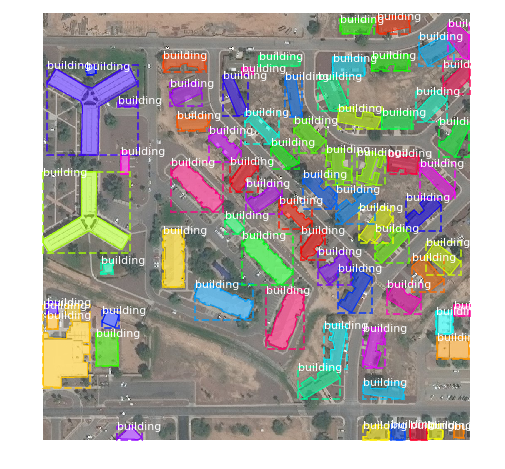

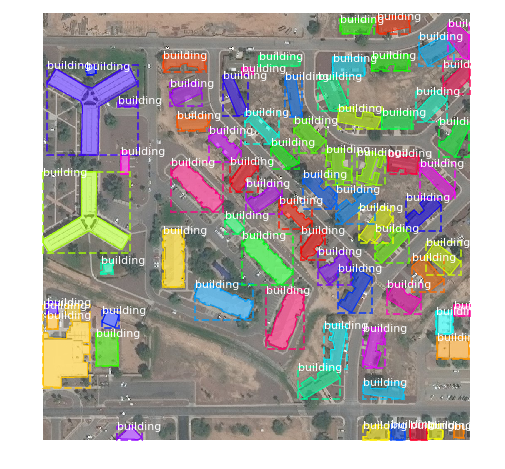

In [7]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, class_names, figsize=(8, 8))

UnboundLocalError: local variable 'fig' referenced before assignment

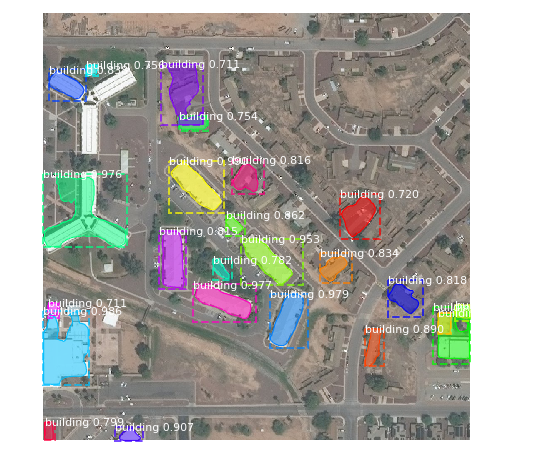

In [8]:
results = model.detect([original_image], verbose=0)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [9]:
val_images = os.listdir(os.path.join(dataset_path,"valimages"))

In [13]:

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
#image_ids = np.random.choice(dataset_val.image_ids, 10)

image_ids = np.random.choice(dataset_val.image_ids, len(val_images))
APs = []
f1s = []


for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
    #f1 = utils.compute_f1_spacenet(gt_bbox, gt_class_id, gt_mask,r["rois"], r["class_ids"], r["scores"], r['masks'])
    f1 = utils.compute_f1(gt_bbox, gt_class_id, gt_mask,r["rois"], r["class_ids"], r["scores"], r['masks'])
    f1s.append(f1)
    
#     visualize.display_instances_orig(image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_val.class_names, r['scores'], ax=get_ax())
    
print("mAP: ", np.mean(APs))
print("F1: ", np.mean(f1s))

mAP:  0.46115660505298767
F1:  0.5271516477624018


In [14]:
round(np.mean(APs)*100,1)

46.1

In [15]:
round(np.mean(f1s)*100,1)

52.7